# Réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

# 0. Chargement des modules et données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

from sklearn import preprocessing, model_selection

In [2]:
df = pd.read_csv('market_data_pd.csv',sep=',')

In [3]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]

In [4]:
#RENSEIGNER LES RATIOS FINANCIERS / VARIABLES CONSIDEREES 

df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"TCE Ratio","PD_1y"]]


df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df1.replace(np.nan, 0.0,inplace=True)


<ipython-input-4-054a43615616>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
C:\Users\mathilde.binet\Anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [5]:
#df1 = df1.dropna(how = 'any') 
df1.head()

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3,TCE Ratio,PD_1y
0,4.84431,684.499,Banking,4.45822,0.006788
1,17.15800,351.535,Consumer Cyclical,-171.02700,0.065377
2,17.15800,351.535,Consumer Cyclical,-171.02700,0.116526
3,19.24570,410.513,Basic Industry,0.00000,0.014829
4,19.24570,410.513,Basic Industry,0.00000,0.009303


In [6]:
df1.shape

(549, 5)

# 1. Préparation des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [7]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [8]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

## a. Statistiques descriptives

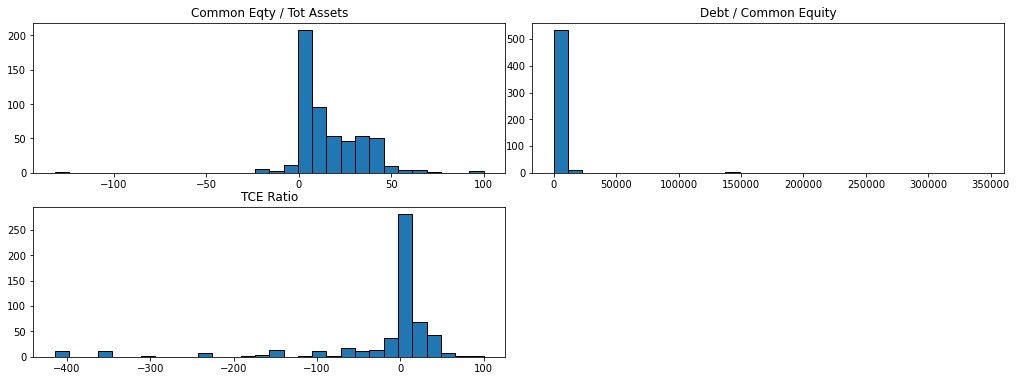

In [9]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(4, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=0.1)

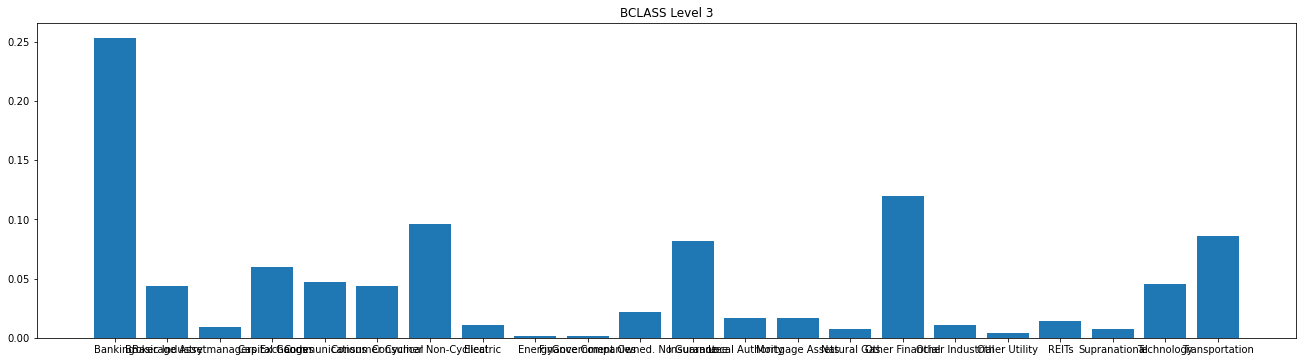

In [10]:
# Bar plots for discrete features
fig = plt.figure(figsize=(18, 14))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(3, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
fig.tight_layout(pad=0.35)

## b. Traitement des données

### Première version de traitement des données (beug sur subtilité bases de train/test)

In [15]:
def traitement(X):
    
    ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False)
    
    std_scaler = preprocessing.StandardScaler().fit(X[:,continuous_features_idx])
    X_continuous_scaled = std_scaler.transform(X[:,continuous_features_idx])
    
    X_processed = np.hstack((ohe.fit_transform(X[:,discrete_features_idx]), X_continuous_scaled))
    
    return X_processed



In [16]:
X_processed = traitement(X_full)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

In [17]:
X_train.shape

(494, 25)

### Version corrigée (à rechercker)

Séparation en base de test / train. Besoin de distinguer les cas selon le type de variables : 

$-$ variables quali : les binariser avant de séparer en test et train afin d'avoir des colonnes pour toutes les modalités existantes dans le dataset. 

$-$ variable quanti : il faut les standariser en fonction de la base de train, càd : on entraîne la standardisation QUE sur la base de train, puis on applique les coefficients à la base de test également. Important, **sinon notre base de train dépend de la base de test**.

*Transformation des qualis*

In [11]:
def traitement_quali(X):
    
    ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False)
    
    X_processed = np.hstack((ohe.fit_transform(X[:,discrete_features_idx]), X[:,continuous_features_idx]))
    
    return X_processed

In [12]:
nbvar_avant = len(X_full[0])

X_full = traitement_quali(X_full)

nbvar_après = len(X_full[0])
nb_quali = nbvar_après - nbvar_avant + len(discrete_features_idx)

In [13]:
nb_quali

22

*Séparation test et train*

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.20,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

*Transformation des quantis*

In [15]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(X_train[:,continuous_features_idx])
StandardScaler(copy = True, with_mean = True, with_std = True)

X_train_quanti = scaler.transform(X_train[:,continuous_features_idx])

In [16]:
x_3quali = pd.DataFrame(X_train_quanti)
x_3quanti = pd.DataFrame(X_train[:,:nb_quali])
x_3quali = x_3quali.reset_index()
x_3quanti = x_3quanti.reset_index()
x_3quali = x_3quali.apply(pd.to_numeric)
x_3quanti = x_3quanti.apply(pd.to_numeric)
X_train = pd.merge(x_3quanti, x_3quali, how='inner', on="index")
X_train = X_train.drop(columns = ['index']) 

X_train = np.array(X_train)

In [17]:
X_test_quanti = scaler.transform(X_test[:,continuous_features_idx])

x_4quali = pd.DataFrame(X_test_quanti)
x_4quanti = pd.DataFrame(X_test[:,:nb_quali])
x_4quali = x_4quali.apply(pd.to_numeric)
x_4quanti = x_4quanti.apply(pd.to_numeric)
x_4quali = x_4quali.reset_index()
x_4quanti = x_4quanti.reset_index()
X_test = pd.merge(x_4quanti, x_4quali, how='inner', on="index")
X_test = X_test.drop(columns = ['index']) 

X_test = np.array(X_test)

# II. Réseaux de neurones : prédiction de la PD

## a. Implémentation du modèle

In [16]:
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

In [18]:
model = Sequential()
model.add(Dense(units=6,input_dim=25,activation="sigmoid")) #6 is good
model.add(Dense(units=2))
model.add(Dense(units=1,activation="sigmoid"))
#modele.add(Dropout(0.3))
learning_rate = 0.10

sgd = SGD(learning_rate)

#dim première couche = nombre de variables du df 

**Fonction sigmoïde :** continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [19]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.3692 - mean_squared_error: 0.3692 - val_loss: 0.3229 - val_mean_squared_error: 0.3229
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.2919 - mean_squared_error: 0.2919 - val_loss: 0.2566 - val_mean_squared_error: 0.2566
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.2315 - mean_squared_error: 0.2315 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1608 - val_mean_squared_error: 0.1608
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.1057 - mean_squared_error: 0.1057 - val_loss: 0.0937 - val_mean_squared_error: 0.0937
Epoch 7/50
40/40 [======================

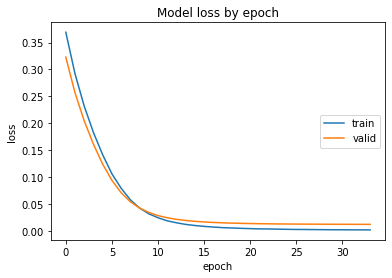

In [21]:
history = model.fit(X_train, y_train,         # Train the model using the training set...
          batch_size=10, epochs=50,
          verbose=1, validation_split=0.4,steps_per_epoch=40)           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [22]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MSE):', resultat[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Valeur de l'erreur sur les données de test (loss): 0.0011322676436975598
Précision sur les données de test (MSE): 0.0011322676436975598


## b. Observation des résultats 

In [23]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

In [24]:
prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
prediction, théorique = prediction.reset_index() , théorique.reset_index()

results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

<ipython-input-23-4a18010dd972>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return abs(théo - préd) / théo


In [25]:
results.replace(np.inf, 0.0,inplace=True)

In [26]:
results

,Théorique,Prédiction,Ecart_relatif
0,0.001887,0.045909,23.335298
1,0.060525,0.044402,0.266384
2,0.005515,0.039607,6.181250
3,0.013885,0.048804,2.514814
4,0.002858,0.064471,21.559225
...,...,...,...
105,0.040653,0.044402,0.092215
106,0.012875,0.046116,2.581839
107,0.129664,0.064471,0.502789
108,0.014909,0.046116,2.093100


In [28]:
print("L'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")

L'écart relatif moyen est de 672.9779666619127%


In [29]:
results.sort_values('Ecart_relatif',inplace=True)

In [31]:
#results

(-0.01, 0.1)

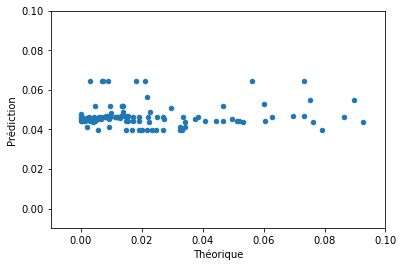

In [30]:
results.plot.scatter("Théorique","Prédiction")
plt.xlim(-.01,.1)
plt.ylim(-.01,.1)

---------------

# III. Réseaux de neurones : Test classification multi-classe

In [31]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y","TCE Ratio"]]
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
df = df[df.PD_1y<0.05]

df['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df.replace(np.nan, 0.0,inplace=True)

## a. Classification des PD

**Première version de traitement des données (beug sur subtilité bases de train/test)**

In [ ]:
#ATTENTION : CHANGEMENT A FAIRE 
#il faut paramétrer les algorithmes de classification seulement en utilisant la base de train. 
#et ensuite seulement, appliquer la classification sur la base de test 

#sinon, tu utilises une base normalement inconnue (la base de test) pour paramétrer ton algo. 
#(même si le changement est pas ouf, il faut inverser l'ordre dans lequel on fait ça)

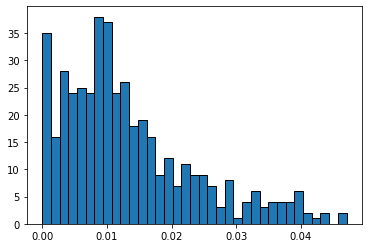

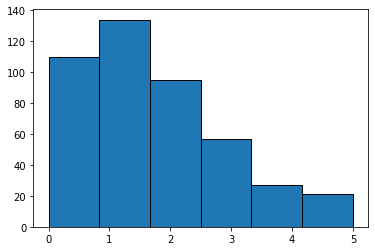

In [56]:
from numpy.random import randn
from sklearn.preprocessing import KBinsDiscretizer

data = np.array(df['PD_1y'])
# histogram of the raw data
plt.hist(data, bins=35,edgecolor='black')
plt.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))
# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(data)

# summarize first few rows
#print(data_trans[:10, :])
# histogram of the transformed data
plt.hist(data_trans, bins=6,edgecolor='black' )
plt.show()

In [57]:
df['PD_1y'] = data_trans

In [58]:
X_full = np.array(df.drop(columns=['PD_1y']))
y_full = np.array(df['PD_1y'])

features = list(df.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]


X_processed = traitement(X_full)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.30,
                                                                    stratify=y_full, # stratification
                                                                    random_state=92)

**Version corrigée (à rechercker)**

In [21]:
#Au départ : reprendre base de train et de test créées dans la partie I. 
#X_train, y_train, X_test, y_test

In [32]:
#à spécifier : le nombre de classes 

nb_class = 6

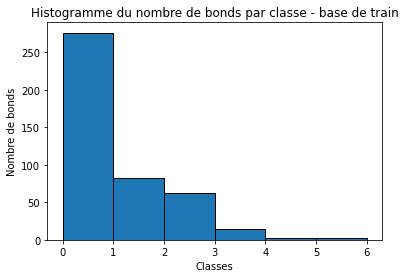

In [68]:
#entraînement de l'algo de classification sur la base de train
from numpy.random import randn
from sklearn.preprocessing import KBinsDiscretizer

y_train2 = y_train.reshape((len(y_train),1))

kbins = KBinsDiscretizer(n_bins=nb_class, encode='ordinal', strategy='kmeans')
y_train_class = kbins.fit_transform(y_train2)

plt.hist(y_train_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

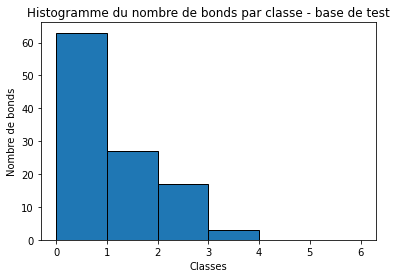

In [69]:
#application de l'algo à la base de train
y_test2 = y_test.reshape((len(y_test),1))
y_test_class = kbins.transform(y_test2)

plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

## b. Implémentation du modèle

In [70]:
model = Sequential()
model.add(Dense(units=6,input_dim=25)) #6 is good
#model.add(Dense(units=2))
model.add(Dense(units=6,activation="sigmoid")) #output


In [71]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [629]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [72]:
history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=10, epochs=20,
          verbose=1, validation_split=0.4,steps_per_epoch=20)  

Epoch 1/20
20/20 [==============================] - 1s 11ms/step - loss: 1.7679 - sparse_categorical_accuracy: 0.1400 - val_loss: 1.7223 - val_sparse_categorical_accuracy: 0.0966
Epoch 2/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7329 - sparse_categorical_accuracy: 0.1554 - val_loss: 1.6742 - val_sparse_categorical_accuracy: 0.1932
Epoch 3/20
20/20 [==============================] - 0s 4ms/step - loss: 1.6403 - sparse_categorical_accuracy: 0.2176 - val_loss: 1.6276 - val_sparse_categorical_accuracy: 0.4034
Epoch 4/20
20/20 [==============================] - 0s 4ms/step - loss: 1.6003 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.5828 - val_sparse_categorical_accuracy: 0.4091
Epoch 5/20
20/20 [==============================] - 0s 4ms/step - loss: 1.5680 - sparse_categorical_accuracy: 0.5389 - val_loss: 1.5429 - val_sparse_categorical_accuracy: 0.5568
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 1.5111 - sparse_categorical_accuracy:

4/4 [==============================] - 0s 9ms/step - loss: 1.2083 - sparse_categorical_accuracy: 0.5727
The final loss on the TEST set is: 1.21.
The final sparse_categorical_accuracy on the TEST set is: 0.57.


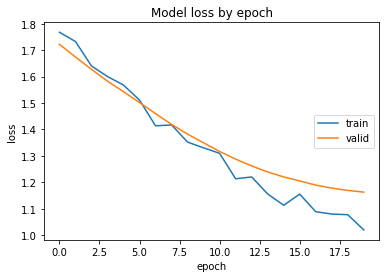

In [73]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [74]:
y=model.predict(X_test)

In [75]:
y_predicted

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [59]:
y_predicted = [np.argmax(pred) for pred in y]

In [77]:
for i in range(len(y_predicted)):
    print("predicted: ", y_predicted[i], "| Actual Label: ",y_test_class[i][0], " True" if (y_predicted[i]==y_test_class[i][0]) else " False")
print("\n")
print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))

predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  2.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  2.0  False
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  2.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  0.0  True
predicted:  0 | Actual Label:  2.0  False
predicted:  0 | Actual Label:  1.0  False
pre

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [79]:
CM = confusion_matrix(y_test_class[:,0], y_predicted)

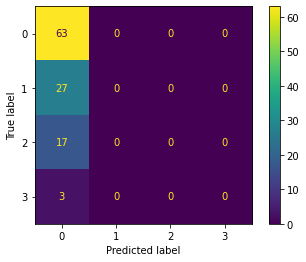

In [80]:
ConfusionMatrixDisplay(CM).plot()

c'est une catastrophe ptdr 